# Lecture 3

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## Clarification on Indices

In [4]:
mottos = pd.read_csv('mottos.csv', index_col='State')
mottos

,Motto,Translation,Language,Date Adopted
State,,,,
Alabama,Audemus jura nostra defendere,We dare defend our rights!,Latin,1923
Alaska,North to the future,—,English,1967
Arizona,Ditat Deus,God enriches,Latin,1863
...,...,...,...,...
West Virginia,Montani semper liberi,Mountaineers are always free,Latin,"September 26, 1863"
Wisconsin,Forward,—,English,1851
Wyoming,Equal Rights,—,English,1893


In [9]:
mottos.loc['Arizona', 'Translation']

'God enriches'

In [11]:
mottos.iloc[2, 1] # Gets element at row position 2 and column position 1

'God enriches'

# An Overview of Pandas GroupBy

This exercise is inspired by Wes McKinney's [Python for Data Analysis](http://proquest.safaribooksonline.com.libproxy.berkeley.edu/book/programming/python/9781491957653).

In [14]:
df = pd.read_csv("elections.csv")
df

,Candidate,Party,%,Year,Result
0,Reagan,Republican,50.7,1980,win
1,Carter,Democratic,41.0,1980,loss
2,Anderson,Independent,6.6,1980,loss
...,...,...,...,...,...
20,Romney,Republican,47.2,2012,loss
21,Clinton,Democratic,48.2,2016,loss
22,Trump,Republican,46.1,2016,win


## Grouping a Series by a Series

Let's group the `%` Series by the `Party` Series. A call to [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) does that, but what is the object that results?

In [15]:
percent_grouped_by_party = df['%'].groupby(df['Party'])
type(percent_grouped_by_party)

pandas.core.groupby.generic.SeriesGroupBy

As we see, `percent_grouped_by_party` is **NOT** a DataFrame, Series, or Index. Instead, it's a `SeriesGroupBy` object. A `SeriesGroupBy` consists of `groups`, one for each of the distinct values of the `Party` column. If we ask to see these groups, we'll be able to see which indices in the original DataFrame correspond to each group.

In [16]:
percent_grouped_by_party.groups

{'Democratic': Int64Index([1, 4, 6, 7, 10, 13, 15, 17, 19, 21], dtype='int64'),
 'Independent': Int64Index([2, 9, 12], dtype='int64'),
 'Republican': Int64Index([0, 3, 5, 8, 11, 14, 16, 18, 20, 22], dtype='int64')}

The `percent_grouped_by_party` object is capable of making computations across all these groups. For example, if we call the `mean` method of the `SeriesGroupBy` class, we'll get a new `Series` containing the mean of the "Democratic" `Series`, the mean of the "Independent" `Series`, and the mean of the "Republican" `Series`.

In [17]:
percent_grouped_by_party.mean()

Party
Democratic     46.53
Independent    11.30
Republican     47.86
Name: %, dtype: float64

The output of the `mean` methood is a regular ole pandas Series.

In [18]:
type(percent_grouped_by_party.mean())

pandas.core.series.Series

`SeriesGroupBy` objects have many other handy methods, e.g. max and min.

In [19]:
percent_grouped_by_party.max()

Party
Democratic     52.9
Independent    18.9
Republican     58.8
Name: %, dtype: float64

In [20]:
percent_grouped_by_party.min()

Party
Democratic     37.6
Independent     6.6
Republican     37.4
Name: %, dtype: float64

In [21]:
percent_grouped_by_party.size()

Party
Democratic     10
Independent     3
Republican     10
Name: %, dtype: int64

In [22]:
percent_grouped_by_party.first()

Party
Democratic     41.0
Independent     6.6
Republican     50.7
Name: %, dtype: float64

We can iterate over a `SeriesGroupBy` object. Each element is a pair of `(name, group)`, where `name` is a String label for the group, and `group` is a `Series` corresponding to all the values from that group.

In [23]:
from IPython.display import display  # like print, but for complex objects

for name, group in percent_grouped_by_party:
    print('Name:', name)
    print(type(group))
    display(group.head())
    print('\n')

Name: Democratic
<class 'pandas.core.series.Series'>


1     41.0
4     37.6
6     45.6
7     43.0
10    49.2
Name: %, dtype: float64



Name: Independent
<class 'pandas.core.series.Series'>


2      6.6
9     18.9
12     8.4
Name: %, dtype: float64



Name: Republican
<class 'pandas.core.series.Series'>


0     50.7
3     58.8
5     53.4
8     37.4
11    40.7
Name: %, dtype: float64

## Grouping a Series by Multiple Series

We can also group a Series by multiple Series. For example, suppose we want to track all combinations of `{'Democratic', 'Republican', and 'Independent'}` and `{'win', 'loss'}`. 

In [44]:
percent_grouped_by_party_and_result = df['%'].groupby([df['Party'], df['Result']])
percent_grouped_by_party_and_result.groups

{('Democratic', 'loss'): Int64Index([1, 4, 6, 13, 15, 21], dtype='int64'),
 ('Democratic', 'win'): Int64Index([7, 10, 17, 19], dtype='int64'),
 ('Independent', 'loss'): Int64Index([2, 9, 12], dtype='int64'),
 ('Republican', 'loss'): Int64Index([8, 11, 18, 20], dtype='int64'),
 ('Republican', 'win'): Int64Index([0, 3, 5, 14, 16, 22], dtype='int64')}

Given this groupby object, we can compute the average percentage earned every time each of the parties won and lost the presidential election. We see that at least between 1980 and 2016, the Republicans have typically lost and won their elections by wider margins.

In [45]:
party_result_mean = percent_grouped_by_party_and_result.mean()
party_result_mean

Party        Result
Democratic   loss      44.85
             win       49.05
Independent  loss      11.30
Republican   loss      42.75
             win       51.27
Name: %, dtype: float64

The careful reader will note that the returned object looks a little funny. It seems to have two indexes! If we check the type of this object, we'll see it's just a regular Series.

In [46]:
type(party_result_mean)

pandas.core.series.Series

However if we request to see the index of this `Series`, we see that it is a "MultiIndex", which is a special type of index used for data that is indexed in two or more ways.

In [47]:
party_result_mean.index

MultiIndex(levels=[['Democratic', 'Independent', 'Republican'], ['loss', 'win']],
           codes=[[0, 0, 1, 2, 2], [0, 1, 0, 0, 1]],
           names=['Party', 'Result'])

Selecting an element of a multi-index gives you a series with just an index.

In [48]:
party_result_mean['Republican']

Result
loss    42.75
win     51.27
Name: %, dtype: float64

Or you can select both levels at once.

In [49]:
party_result_mean['Democratic', 'win']

49.05

Or you can slice.

In [50]:
party_result_mean[:, "loss"]

Party
Democratic     44.85
Independent    11.30
Republican     42.75
Name: %, dtype: float64

## Grouping a DataFrame by a Series

We can also group an entire dataframe by one or more Series. The result is a `DataFrameGroupBy` object:

In [51]:
everything_grouped_by_party = df.groupby('Party')
everything_grouped_by_party

As in our previous example, this object contains three `group` objects, one for each party label.

In [52]:
everything_grouped_by_party.groups

{'Democratic': Int64Index([1, 4, 6, 7, 10, 13, 15, 17, 19, 21], dtype='int64'),
 'Independent': Int64Index([2, 9, 12], dtype='int64'),
 'Republican': Int64Index([0, 3, 5, 8, 11, 14, 16, 18, 20, 22], dtype='int64')}

Just as with `SeriesGroupBy` objects, we can iterate over a `DataFrameGroupBy` object to understand what is effectively inside.

In [53]:
for n, g in everything_grouped_by_party:
    print('name:', n)
    display(g.head())

name: Democratic


,Candidate,Party,%,Year,Result
1,Carter,Democratic,41.0,1980,loss
4,Mondale,Democratic,37.6,1984,loss
6,Dukakis,Democratic,45.6,1988,loss
7,Clinton,Democratic,43.0,1992,win
10,Clinton,Democratic,49.2,1996,win


name: Independent


,Candidate,Party,%,Year,Result
2,Anderson,Independent,6.6,1980,loss
9,Perot,Independent,18.9,1992,loss
12,Perot,Independent,8.4,1996,loss


name: Republican


,Candidate,Party,%,Year,Result
0,Reagan,Republican,50.7,1980,win
3,Reagan,Republican,58.8,1984,win
5,Bush,Republican,53.4,1988,win
8,Bush,Republican,37.4,1992,loss
11,Dole,Republican,40.7,1996,loss


And just like `SeriesGroupBy` objects, we can apply methods like `mean` to compute the mean of each group. Since a `DataFrameGroupBy` is linked to the entire original dataframe (instead of to a single column from the dataframe), we calculate a mean for every numerical column. In this example below, we get the mean vote earned (as before), and the mean year (which isn't a useful quantity).

In [54]:
everything_grouped_by_party.mean()

,%,Year
Party,,
Democratic,46.53,1998.00
Independent,11.30,1989.33
Republican,47.86,1998.00


Where did all the other columns go in the mean above? They are *nuisance columns*, which get automatically eliminated from an operation where it doesn't make sense (such as a numerical mean).

## Grouping a DataFrame by Multiple Series

DataFrames may also be grouped by multiple series at once. For example, we can repeat what we did with a Series above and group the entire DataFrame by Party and Result. After aggregation, we end up with a DataFrame that has a MultiIndex.

In [55]:
everything_grouped_by_party_and_result=df.groupby([df['Party'], df['Result']])

In [56]:
everything_grouped_by_party_and_result.max()

Candidate     %  Year
Party       Result                      
Democratic  loss     Mondale  48.4  2016
            win        Obama  52.9  2012
Independent loss       Perot  18.9  1996
Republican  loss      Romney  47.2  2012
            win        Trump  58.8  2016

The resulting DataFrame above is pretty strange. We'll observe that Walter Mondale did not run for office in 2016! Make sure you understand why this is happening, as this sort of thing is a common mistake made by people who don't fully understand how pandas works.

**Question**: How do you generate a table like the one above, except that each entry should represent all attributes of the candidate who got the maximum vote in that category? For example, the Republican Win category should feature Reagan in 1984 with 58.8% of the vote. *Hint*: Try sorting.

    .
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    .

In [57]:
(df.sort_values("%", ascending=False).
    groupby([df['Party'], df['Result']]).
    first())

Candidate        Party     %  Year Result
Party       Result                                          
Democratic  loss        Gore   Democratic  48.4  2000   loss
            win        Obama   Democratic  52.9  2008    win
Independent loss       Perot  Independent  18.9  1992   loss
Republican  loss      Romney   Republican  47.2  2012   loss
            win       Reagan   Republican  58.8  1984    win

The result of an aggregation function applied to a DataFrameGroupBy 

## Pivot Tables

Recall from before that we were able to group the % Series by the "Party" and "Result" Series, allowing us to understand the average vote earned by each party under each election result.

In [73]:
percent_grouped_by_party_and_result = df['%'].groupby([df['Party'], df['Result']])
percent_grouped_by_party_and_result.mean()

Party        Result
Democratic   loss      44.85
             win       49.05
Independent  loss      11.30
Republican   loss      42.75
             win       51.27
Name: %, dtype: float64

Because we called `groupby` on a Series, the result of our aggregation operation was also a Series. However, I believe this data is more naturally expressed in a tabular format, with Party as the rows, and Result as the columns. The `pivot_table` operation is the natural way to achieve this data format.

In [74]:
df_pivot = df.pivot_table(
    index='Party', # the rows (turned into index)
    columns='Result', # the column values
    values='%', # the field(s) to processed in each group
    aggfunc=np.mean, # group operation
)
df_pivot.head()

Result,loss,win
Party,,
Democratic,44.85,49.05
Independent,11.30,NaN
Republican,42.75,51.27


The basic idea is that you specify a Series to be the `index` (i.e. rows) and a Series to be the `columns`. The data in the specified `values` is then grouped by all possible combinations of values that occur in the `index` and `columns` Series. These groups are then aggregated using the `aggfunc`, and arranged into a table that matches the requested `index` and `columns`. The diagram below summarizes how pivot tables are formed. (Diagram inspired by Joey Gonzales). Diagram source at [this link](https://docs.google.com/presentation/d/1FrYg6yd6B-CIgfWLWm4W8vBhfmJ6Qt9dKkN-mlN5AKU/edit#slide=id.g4131093782_0_89).

![groupby](pivot_table_overview.png)

For more on pivot tables, see [this excellent tutorial](http://pbpython.com/pandas-pivot-table-explained.html) by Chris Moffitt.

## List Arguments to pivot_table (Extra)

The arguments to our pivot_table method can also be lists. A few examples are given below.

If we pivot such that only our `columns` argument is a list, we end up with columns that are MultiIndexed.

In [ ]:
df.pivot_table(
    index='Result', # the rows (turned into index)
    columns=['Party', 'Candidate'], # the column values
    values='Year', # the field(s) to processed in each group
    aggfunc=list, # group operation
)

If we pivot such that only our `index` argument is a list, we end up with rows that are MultiIndexed.

In [ ]:
df.pivot_table(
    index=['Party', 'Candidate'], # the rows (turned into index)
    columns='Result',# the column values
    values='%', # the field(s) to processed in each group
    aggfunc=np.mean, # group operation
)

If we pivot such that only our values argument is a list, then we again get a DataFrame with multi-indexed Columns.

In [ ]:
df.pivot_table(
    index='Party', # the rows (turned into index)
    columns='Result',# the column values
    values=['%', 'Year'], # the field(s) to processed in each group
    aggfunc=np.mean, # group operation
)

## Custom Aggregation Functions

As described above, both `SeriesGroupBy` and `DataFrameGroupBy` objects have lots of handy methods for computing aggregate values for groups, e.g.

In [58]:
percent_grouped_by_party.min()

Party
Democratic     37.6
Independent     6.6
Republican     37.4
Name: %, dtype: float64

In [59]:
everything_grouped_by_party.median()

,%,Year
Party,,
Democratic,48.25,1998
Independent,8.40,1992
Republican,47.55,1998


It turns out that all of these GroupBy methods are just shorthand for a more powerful and universal method of our GroupBy objects called agg. For example, `.min()` is just shorthand for `.agg(min)`, where `min` refers to the function `min`.

In [60]:
percent_grouped_by_party.agg(min)

Party
Democratic     37.6
Independent     6.6
Republican     37.4
Name: %, dtype: float64

Naturally, we can define our own custom aggregation functions. For example, the function below returns the first item in a series.

In [61]:
def average_of_first_and_last(series):
    return (series.iloc[0] + series.iloc[-1])/2

We can supply this function as a custom aggregation function for each series. As you can see, nuisance columns are automatically removed.

In [62]:
percent_grouped_by_party_and_result.agg(average_of_first_and_last)

Party        Result
Democratic   loss      44.60
             win       47.05
Independent  loss       7.50
Republican   loss      42.30
             win       48.40
Name: %, dtype: float64

`agg` is fundamental to our use of GroupBy objects. Indeed, you will rarely call `groupby` without also calling `agg`, at least implicitly. We can summarize the grouping process with the following diagram, inspired by a similar diagram created by DS100 instructor Joey Gonzales. Diagram source at [this link](https://docs.google.com/presentation/d/1FrYg6yd6B-CIgfWLWm4W8vBhfmJ6Qt9dKkN-mlN5AKU/edit#slide=id.g4131093782_0_40).

![groupby](groupby_overview.png) 

The result of calling `groupby` then `agg` on a `Series` is also a `Series`, and the result of calling `groupby` then `agg` on a `DataFrame` is also typically a `DataFrame`, though there are exceptions, e.g. if you use the aggregation function `size`, you will get back a `Series`.

In [63]:
def list_of_first_and_last(series):
    return [series.iloc[0], series.iloc[-1]]

In [64]:
everything_grouped_by_party.agg(list_of_first_and_last)

,Candidate,%,Year,Result
Party,,,,
Democratic,"[Carter, Clinton]","[41.0, 48.2]","[1980, 2016]","[loss, loss]"
Independent,"[Anderson, Perot]","[6.6, 8.4]","[1980, 1996]","[loss, loss]"
Republican,"[Reagan, Trump]","[50.7, 46.1]","[1980, 2016]","[win, win]"


## Using Groups to Filter Datasets

In [65]:
everything_grouped_by_candidate = df.groupby('Candidate')

In [66]:
everything_grouped_by_candidate.filter(lambda subframe: subframe["Year"].max() > 2000)

,Candidate,Party,%,Year,Result
5,Bush,Republican,53.4,1988,win
7,Clinton,Democratic,43.0,1992,win
8,Bush,Republican,37.4,1992,loss
...,...,...,...,...,...
20,Romney,Republican,47.2,2012,loss
21,Clinton,Democratic,48.2,2016,loss
22,Trump,Republican,46.1,2016,win


In [67]:
everything_grouped_by_year = df.groupby('Year')

In [68]:
everything_grouped_by_year.filter(lambda subframe: subframe["%"].sum() < 97)

,Candidate,Party,%,Year,Result
3,Reagan,Republican,58.8,1984,win
4,Mondale,Democratic,37.6,1984,loss
13,Gore,Democratic,48.4,2000,loss
14,Bush,Republican,47.9,2000,win
21,Clinton,Democratic,48.2,2016,loss
22,Trump,Republican,46.1,2016,win


A visual picture of how filtering works is shown below.

![filter](filter_overview.png)

## Using isin for filtering

This isn't actually related to `groupby` at all, but it seemed natural to bring it up here. 

Sometimes we want to restrict our attention to only rows where certain values appear. For example, we saw last time how we'd look at only rows that contain "Democratic" candidates.

In [69]:
df[df["Party"] == "Democratic"]

,Candidate,Party,%,Year,Result
1,Carter,Democratic,41.0,1980,loss
4,Mondale,Democratic,37.6,1984,loss
6,Dukakis,Democratic,45.6,1988,loss
...,...,...,...,...,...
17,Obama,Democratic,52.9,2008,win
19,Obama,Democratic,51.1,2012,win
21,Clinton,Democratic,48.2,2016,loss


Suppose we wanted to filter such that all Republicans and Democrats appeared. One ugly way to do this would be `df[(df["Party"] == "Democratic") | (df["Party"] == "Republican")]`. However, a better idea is to use the `isin` method.

In [70]:
df[(df["Party"] == "Democratic") | (df["Party"] == "Republican")]

df[df["Party"].isin(["Republican", "Democratic"])]

,Candidate,Party,%,Year,Result
0,Reagan,Republican,50.7,1980,win
1,Carter,Democratic,41.0,1980,loss
3,Reagan,Republican,58.8,1984,win
...,...,...,...,...,...
20,Romney,Republican,47.2,2012,loss
21,Clinton,Democratic,48.2,2016,loss
22,Trump,Republican,46.1,2016,win


## Grouping over a different dimension (bonus topic, less often useful)

Above, we've been grouping data along the rows, using column keys as our selectors.  But we can also group along the columns, for example we can group by how many times the letter a appears in the column name.

In [71]:
grouped = df.groupby(lambda x: x.count('a'), axis=1)
for dtype, group in grouped:
    print(dtype)
    print(group.columns)

0
Index(['%', 'Result'], dtype='object')
1
Index(['Party', 'Year'], dtype='object')
2
Index(['Candidate'], dtype='object')


In [72]:
df.set_index('Candidate').transpose().groupby(len, axis=1).max()

,4,5,6,7,8
Party,Republican,Republican,Republican,Democratic,Independent
%,53,53,59,49,6.6
Year,2004,2016,2012,2016,1980
Result,win,win,win,win,loss


## Getting the Data

https://www.ssa.gov/OACT/babynames/index.html

https://www.ssa.gov/data

We can download data from the internet with Python, and do so only if needed:

In [76]:
import requests
from pathlib import Path

namesbystate_path = Path('namesbystate.zip')
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'

if not namesbystate_path.exists():
    print('Downloading...', end=' ')
    resp = requests.get(data_url)
    with namesbystate_path.open('wb') as f:
        f.write(resp.content)
    print('Done!')

## What were the most popular California male & female names in each year?

### Extracting from a ZIP archive

We can see how large the compressed and uncompressed data are:

In [77]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')
sum(f.file_size for f in zf.filelist) / 1_000_000

122.38892

In [78]:
sum(f.compress_size for f in zf.filelist) / 1_000_000

21.568281

In [79]:
__/_  # divide the next-previous result by the previous one

5.674486529547719

What are these data?

In [80]:
zf.extract('StateReadMe.pdf')

'/Users/sam/repos/ds100/su19-public/lec/lec03/StateReadMe.pdf'

We want the names for California.

In [81]:
print([f.filename for f in zf.filelist])

['AK.TXT', 'AL.TXT', 'AR.TXT', 'AZ.TXT', 'CA.TXT', 'CO.TXT', 'CT.TXT', 'DC.TXT', 'DE.TXT', 'FL.TXT', 'GA.TXT', 'HI.TXT', 'IA.TXT', 'ID.TXT', 'IL.TXT', 'IN.TXT', 'KS.TXT', 'KY.TXT', 'LA.TXT', 'MA.TXT', 'MD.TXT', 'ME.TXT', 'MI.TXT', 'MN.TXT', 'MO.TXT', 'MS.TXT', 'MT.TXT', 'NC.TXT', 'ND.TXT', 'NE.TXT', 'NH.TXT', 'NJ.TXT', 'NM.TXT', 'NV.TXT', 'NY.TXT', 'OH.TXT', 'OK.TXT', 'OR.TXT', 'PA.TXT', 'RI.TXT', 'SC.TXT', 'SD.TXT', 'StateReadMe.pdf', 'TN.TXT', 'TX.TXT', 'UT.TXT', 'VA.TXT', 'VT.TXT', 'WA.TXT', 'WI.TXT', 'WV.TXT', 'WY.TXT']


In [82]:
ca_name = 'CA.TXT'
with zf.open(ca_name) as f:
    for i in range(10):
        print(f.readline().rstrip().decode())

CA,F,1910,Mary,295
CA,F,1910,Helen,239
CA,F,1910,Dorothy,220
CA,F,1910,Margaret,163
CA,F,1910,Frances,134
CA,F,1910,Ruth,128
CA,F,1910,Evelyn,126
CA,F,1910,Alice,118
CA,F,1910,Virginia,101
CA,F,1910,Elizabeth,93


In [92]:
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    ca = pd.read_csv(fh, header=None, names=field_names)
ca

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
...,...,...,...,...,...
374631,CA,M,2017,Zia,5
374632,CA,M,2017,Ziad,5
374633,CA,M,2017,Ziv,5


In [84]:
ca.shape

(374634, 5)

### Group by year

In [93]:
ca[(ca['Year'] == 1995) & (ca['Sex'] == 'M')]

,State,Sex,Year,Name,Count
311664,CA,M,1995,Daniel,5003
311665,CA,M,1995,Michael,4783
311666,CA,M,1995,Jose,4572
...,...,...,...,...,...
314139,CA,M,1995,Zavier,5
314140,CA,M,1995,Zayd,5
314141,CA,M,1995,Zeferino,5


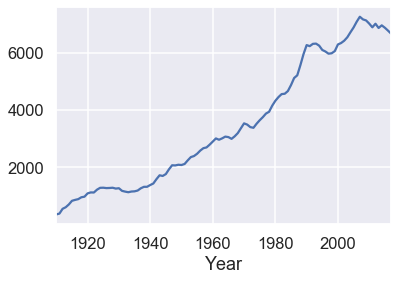

In [86]:
ca.groupby('Year').size().plot();

### Grouping by multiple columns

In [90]:
ca.groupby(['Year', 'Sex']).size()

Year  Sex
1910  F       233
      M       130
1911  F       251
             ... 
2016  M      2904
2017  F      3740
      M      2918
Length: 216, dtype: int64

In [91]:
ca.groupby(['Year', 'Sex']).size()

Year  Sex
1910  F       233
      M       130
1911  F       251
             ... 
2016  M      2904
2017  F      3740
      M      2918
Length: 216, dtype: int64

In [94]:
most_popular_names = (ca.groupby(['Year', 'Sex']).first())
most_popular_names

State  Name  Count
Year Sex                   
1910 F      CA  Mary    295
     M      CA  John    237
1911 F      CA  Mary    390
...        ...   ...    ...
2016 M      CA  Noah   2688
2017 F      CA  Emma   2726
     M      CA  Noah   2511

[216 rows x 3 columns]

As we'd expect, we get a MultiIndexed DataFrame, which we can index using [] just like our single indexed DataFrames.

In [95]:
most_popular_names[most_popular_names['Name'] == 'John']

,,State,Name,Count
Year,Sex,,,
1910,M,CA,John,237
1911,M,CA,John,214
1912,M,CA,John,501
...,...,...,...,...
1915,M,CA,John,1033
1916,M,CA,John,1086
1917,M,CA,John,1066


`.loc` is a bit more complicated:

In [96]:
most_popular_names.loc[2017, :, :]

State  Name  Count
Year Sex                   
2017 F      CA  Emma   2726
     M      CA  Noah   2511

In [97]:
pop_pivot = ca.pivot_table(
    index='Sex',
    columns='Year',
    values='Name',
    aggfunc=lambda ns: ns.iloc[0]
)
pop_pivot

Year,1910,1911,1912,1913,...,2014,2015,2016,2017
Sex,,,,,,,,,
F,Mary,Mary,Mary,Mary,...,Sophia,Sophia,Mia,Emma
M,John,John,John,John,...,Noah,Noah,Noah,Noah


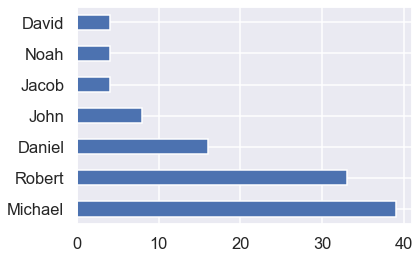

In [98]:
pop_pivot.loc['M'].value_counts().plot(kind='barh');

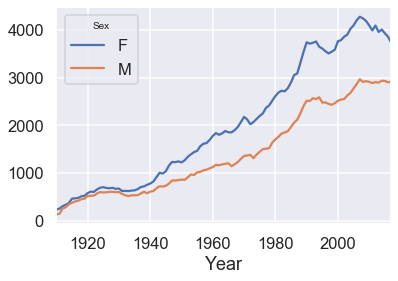

In [99]:
ca.pivot_table(
    index='Year',
    columns='Sex',
    values='Name',
    aggfunc=len,
).plot();

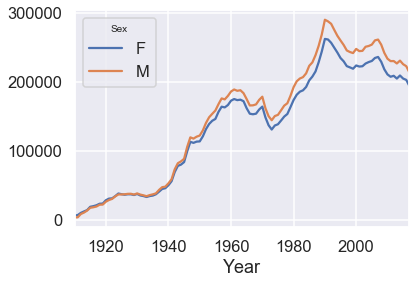

In [100]:
ca.pivot_table(
    index='Year',
    columns='Sex',
    values='Count',
    aggfunc=sum,
).plot();

## Enrollment Practice Questions

In [104]:
df = pd.read_csv("enrollments.csv", usecols=["Term", "Subject", "Number", "Title", "Enrollment Cnt", "Instructor"])
df.head()

,Term,Subject,Number,Title,Instructor,Enrollment Cnt
0,2018 Spring,Computer Science,9A,Programmers' Matlab,Carol Marshall; Paul Hilfinger,8
1,2018 Spring,Computer Science,9C,Programmers' C,Carol Marshall; Paul Hilfinger,11
2,2018 Spring,Computer Science,9E,Productive Unix Use,Carol Marshall; Paul Hilfinger,36
3,2018 Spring,Computer Science,9F,Programmers' C++,Carol Marshall; Paul Hilfinger,33
4,2018 Spring,Computer Science,9G,Programmers' Java,Carol Marshall; Paul Hilfinger,11


## Challenge One

Try to find all Spring offerings of this course. Note, this dataset only contains Spring offerings, so there's no need to filter based on semester. The official "Number" for this class is "C100".

In [105]:
df[df["Number"] == "C100"]

,Term,Subject,Number,Title,Instructor,Enrollment Cnt
20,2018 Spring,Computer Science,C100,Princ&Tech Data Sci,Fernando Perez; Joseph Gonzalez,610
387,2017 Spring,Computer Science,C100,Princ&Tech Data Sci,Bin Yu; Deborah Nolan; Joseph Gonzalez; Joseph...,67
670,2017 Spring,Statistics,C100,Princ&Tech Data Sci,Bin Yu; Deborah Nolan; Joseph Gonzalez; Joseph...,28


## Challenge Two

Create a series where each row correspond to one subject (e.g. English), and each value corresponds to the average number of students for courses in that subject. For example, your series might have a row saying that the average number of students in a Computer Science class is 88.

In [106]:
enrollment_grouped_by_subject = df["Enrollment Cnt"].groupby(df["Subject"])

In [107]:
enrollment_grouped_by_subject.mean()

Subject
Computer Science                 88.07
Electrical Eng & Computer Sci    21.33
Electrical Engineering           36.34
English                          24.39
Philosophy                       41.52
Statistics                       60.30
Name: Enrollment Cnt, dtype: float64

## Challenge Three

Create a multi-indexed series where each row corresponds to one subject (e.g. English) offered during one semester (e.g. Spring 2017), and each value corresponds to the maximum number of students for courses in that subject during that semester. For example, you might have a row saying that the maximum number of students in a computer science course during Spring 2012 was 575.

In [108]:
enrollment_grouped_by_subject_and_term = df["Enrollment Cnt"].groupby([df["Subject"], df["Term"]])

In [109]:
enrollment_grouped_by_subject_and_term.max()

Subject           Term       
Computer Science  2012 Spring     575
                  2013 Spring     529
                  2014 Spring     944
                                 ... 
Statistics        2016 Spring     450
                  2017 Spring     393
                  2018 Spring    1043
Name: Enrollment Cnt, Length: 38, dtype: int64

## Challenge Four

Try to compute the size of the largest class ever taught by each instructor. This challenge is stated more vaguely on purpose. You'll have to decide what the data structure looks like. Your result should be sorted in decreasing order of class size.

In [110]:
enrollment_grouped_by_instructor = df["Enrollment Cnt"].groupby(df["Instructor"])

In [111]:
enrollment_grouped_by_instructor.max().sort_values(ascending=False)

Instructor
Joshua Hug                1379
Joshua Hug; Joshua Hug    1328
John DeNero               1210
                          ... 
Robert Full                  1
Katherine Yelick             1
Lotfi Zadeh                  1
Name: Enrollment Cnt, Length: 745, dtype: int64

## Can I deduce birth sex from the last letter of a person’s name?

### Compute last letter of each name

In [22]:
ca.head()

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134


In [23]:
ca['Name'].str[-1].head()

0    y
1    n
2    y
3    t
4    s
Name: Name, dtype: object

To add column to dataframe:

In [24]:
ca['Last'] = ca['Name'].str[-1]
ca.head()

,State,Sex,Year,Name,Count,Last
0,CA,F,1910,Mary,295,y
1,CA,F,1910,Helen,239,n
2,CA,F,1910,Dorothy,220,y
3,CA,F,1910,Margaret,163,t
4,CA,F,1910,Frances,134,s


### Group by last letter and sex

In [25]:
letter_counts = (ca
                 .loc[:, ('Sex', 'Count', 'Last')]
                 .groupby(['Last', 'Sex'])
                 .sum())
letter_counts.head()

Count
Last Sex         
a    F    5750384
     M     185959
b    F        894
     M     147627
c    F       2889

### Visualize our result

Use .plot to get some basic plotting functionality:

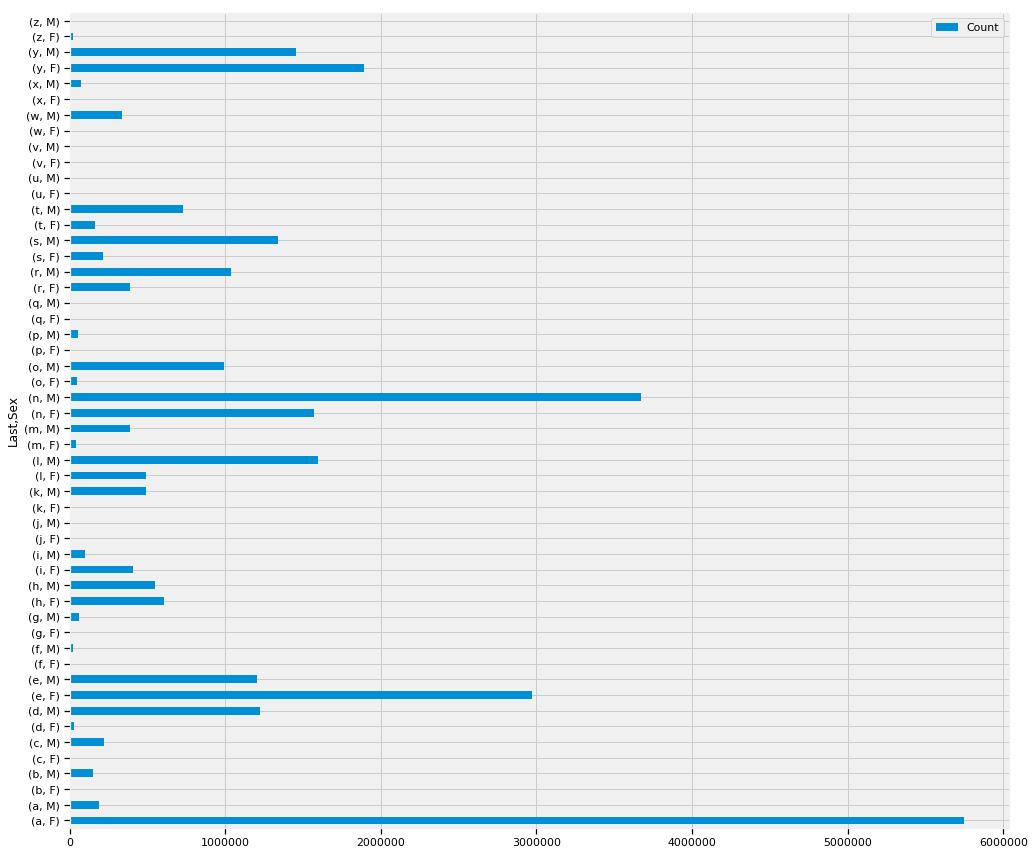

In [26]:
# Why is this not good?
letter_counts.plot.barh(figsize=(15, 15));

Reading the docs shows me that pandas will make one set of bars for each column in my table. How do I move each sex into its own column? I have to use pivot:

In [27]:
# For comparison, the group above:
# letter_counts = (baby_names
#                  .loc[:, ('Sex', 'Count', 'Last letter')]
#                  .groupby(['Last letter', 'Sex'])
#                  .sum())

last_letter_pivot = ca.pivot_table(
    index='Last', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
last_letter_pivot.head()

Sex,F,M
Last,,
a,5750384,185959
b,894,147627
c,2889,219350
d,28728,1222725
e,2974686,1206604


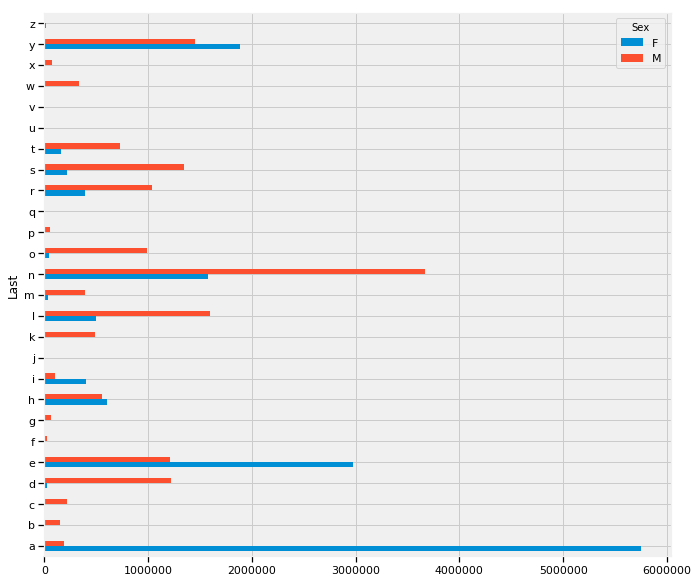

In [28]:
last_letter_pivot.plot.barh(figsize=(10, 10));

Why is this still not ideal?

- Plotting raw counts
- Not sorted by any order

In [29]:
totals = last_letter_pivot['F'] + last_letter_pivot['M']

last_letter_props = pd.DataFrame({
    'F': last_letter_pivot['F'] / totals,
    'M': last_letter_pivot['M'] / totals,
}).sort_values('M')
last_letter_props.head()

,F,M
Last,,
a,0.968674,0.031326
i,0.804707,0.195293
e,0.711428,0.288572
z,0.689834,0.310166
y,0.564982,0.435018


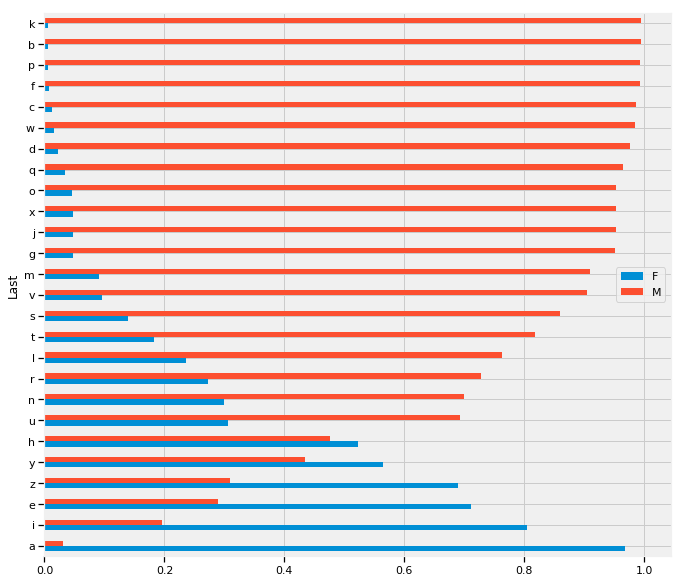

In [30]:
last_letter_props.plot.barh(figsize=(10, 10));